According to the background given, Cocacola launched a new packaging and labels to fix the stagnation in sales with Millenials (born in 1981-1996). However, I did not see the given tasks I did in WSW_ver1 as the best way to analyze the new launch's performance. Therefore, I constructed a new analaysis process to analyze the performance in this WSW_ver2.
Also, there's no way to identify people's generation in the dataset (no birthdays or age), so I will assume that the one who collected the data limited these from users who are Millenials for this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import nltk
import re

In [2]:
# import data, and shows the head of the dataset for preview
df = pd.read_csv('Diet Coke Raw Data.csv',skiprows=5,low_memory=False)
df.head() #for preview

,Author,Blog_Comments,Date,Facebook_Comments,Facebook_Likes,Full_Text,Instagram_Comments,Instagram_Followers,Instagram_Likes,Page_Type,Sentiment,Thread_Entry_Type,Thread_URL,Twitter_Followers,Twitter_Reply_Count,Twitter_Reply_to,Twitter_Retweets,Url
0,vic91597,0.0,2018-01-16 16:24:24.0,0.0,0.0,RT @misler_shane: Reply with your venmo/paypal...,0.0,0.0,0.0,twitter,0.5,share,NaN,303.0,0,NaN,0.0,NaN
1,ENRIKAY_,0.0,2018-01-08 02:17:07.0,0.0,0.0,Weirdest white ppl I ever seen play pool here ...,0.0,0.0,0,twitter,0.5,post,NaN,216.0,0,NaN,0,NaN
2,jfranco707,0.0,2017-11-30 01:41:22.0,0.0,0.0,RT @BillyLeslie22: “if you call the uber i’ll ...,0.0,0.0,0,twitter,0.5,share,NaN,390.0,0,NaN,0,NaN
3,acide.mat,0.0,2018-01-11 04:55:47.0,0.0,0,✖️LCLB✖️\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n...,0,0.0,0,instagram,0.5,post,NaN,0.0,0,NaN,0,NaN
4,_Shinyy_21,0.0,2017-12-05 18:25:07.0,0.0,0,@Oliviaaaaascho I miss getting diet Coke’s wit...,0.0,0.0,0,twitter,0.5,reply,NaN,1047.0,0,http://twitter.com/Oliviaaaaascho/statuses/938...,0,NaN


# Data Cleaning & Grouping

In [3]:
##data cleaning - String columns

df['Page_Type']=df['Page_Type'].str.lower() #Page Types had inconisistent capitalization
df=df.dropna(subset=['Author','Full_Text']) #Not reliable or useful if Author or full text is nonexistent
df=df[df.Page_Type.isin(['instagram','twitter','forum','facebook','news','blog'])] #only keeping significant groups

In [4]:
##data cleaning - Numeric columns

#Converting values in numeric into integer for easier calculations, and sum groupable numbers into one column for smaller dataset(Quicker work)
engage=['Blog_Comments','Facebook_Comments','Facebook_Likes','Instagram_Comments','Instagram_Likes','Twitter_Reply_Count','Twitter_Retweets'] 
df[engage]=df[engage].apply(pd.to_numeric,downcast='integer',errors='coerce')
df['Social_Engagements']=df[engage].sum(axis=1)
df=df.drop(engage,axis=1)


followers=['Instagram_Followers','Twitter_Followers']
df[followers]=df[followers].apply(pd.to_numeric,downcast='integer',errors='coerce')
df['Followers']=df[followers].sum(axis=1)
df=df.drop(followers,axis=1)

#Sentiment should have float values
df.Sentiment = df.Sentiment.apply(pd.to_numeric, downcast='float',errors='coerce').dropna()



In [5]:
## data grouping - miscellaneous
df['Category']=df['Page_Type'].map({'twitter':'Social','instagram':'Social', 'facebook':'Social',
                                   'news':'News','blog':'Blog & Forum','forum':'Blog & Forum'}) #mapping into types


In [6]:
df['Date']=pd.to_datetime(df.Date)
df['Weeks']=df.Date.dt.isocalendar().week
df['Years']=df.Date.dt.isocalendar().year
df['Years']=df['Years'].where(df['Years']!=1917,2017) #replacing 1917 to 2017

# Update Sentiments, Tag Emotions

In [7]:
#Tag emotions, using Emotion Keywords

emotions=pd.read_csv('Emotions Keywords.csv') #import keywords csv
emotions.head() #for preview
emotions_key=emotions.columns #emotion list
emotions['Stressful']=emotions['Stressful'].drop_duplicates() #I found that there are two stressful-s

for i in range(len(emotions.columns)): #for each emotions
    emotion_list = emotions.iloc[:,i].dropna().tolist() #clean list of values of the iterated emotion
    emo_regexs= re.compile(r'\b(:{})\b'.format('|'.join(emotion_list))) #make regex out of list
    emo_bool=df.Full_Text.str.contains(emo_regexs) #does the list have the regex
    emo_tag_new=emo_bool.map(lambda emotion: [emotions_key[i]] if emotion==True else []) #put list with emotion name or empty list
    if i == 0: emo_tag_sum = emo_tag_new #for the first iteration, we don't have sum to combine with new
    else: emo_tag_sum=emo_tag_new+emo_tag_sum #combine two lists of series into new series
        


/var/folders/p8/ggm3r0bx14sbjsb1ksyg2y6c0000gn/T/ipykernel_10593/2897623610.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  emo_bool=df.Full_Text.str.contains(emo_regexs) #does the list have the regex


In [8]:
df['Emotions']=emo_tag_sum.apply(tuple) #add it to the dataframe

In [9]:
#Update Sentiments Using Vader

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

df['New_Sentiment'] = df['Full_Text'].apply(lambda mention: list(sent.polarity_scores(mention).values())) 
#new sentiment now contians list of neg,neu,pos,compound
#The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/syunie/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
#for result visualization
df['New_Pos']=df['New_Sentiment'].apply(lambda emotion: emotion[0])
df['New_Neg']=df['New_Sentiment'].apply(lambda emotion: emotion[1])
df['New_Neu']=df['New_Sentiment'].apply(lambda emotion: emotion[2])
df['New_Com']=df['New_Sentiment'].apply(lambda emotion: emotion[3])
df=df.drop('New_Sentiment',axis=1)

In [11]:
#for output visualization
print(df.Emotions.value_counts())
print()
print()
print()
print(df[['New_Pos','New_Neg','New_Neu','New_Com']].head())

()                                  704224
(Sad,)                                7709
(Thankful,)                           6175
(Angry,)                              5559
(Pleasant,)                           5403
                                     ...  
(Anxiety, Pleasant, Surprise)            1
(Frustration, Anxiety, Restful)          1
(Anxiety, Thankful, Surprise)            1
(Sad, Angry, Thankful, Surprise)         1
(Stressful, Annoy)                       1
Name: Emotions, Length: 120, dtype: int64



   New_Pos  New_Neg  New_Neu  New_Com
0    0.000    0.660    0.340   0.8513
1    0.168    0.619    0.212   0.1280
2    0.289    0.711    0.000  -0.5667
3    0.000    1.000    0.000   0.0000
4    0.127    0.556    0.317   0.5267


# Topics of Each Mentions

What are each mentions talking about?

In [12]:
#initiate Series objects
aboutrow=pd.Series(dtype=str) 
abouteach=pd.Series(dtype=str) 
handles = pd.read_csv('Brand Official Handle Keywords.csv')
brand_keys=handles.keys().tolist()

#iterate for all brands
for i in range(len(brand_keys)):
    abouteach= df.Full_Text.map(lambda txt: brand_keys[i] if (brand_keys[i].lower() in txt) else None )
    aboutrow=aboutrow.combine(abouteach, lambda row, each: each if each==brand_keys[i] else row)

df['About']=aboutrow #add new column of df for collective brand tags

In [13]:
print(df.About.value_counts())

Venmo                111576
Diet Coke             56698
Glossier              53558
LaCroix               32845
Birchbox              12491
Bonobos                3635
Everlane               2945
Casper                 1497
Dollar Shave Club      1481
Warby Parker            532
Vita Coco               139
Name: About, dtype: int64


# Find Target Group by Sentiments

In order to separate actual customer reactions from the ad posts from official accounts, I tagged the official posts with each brand names and left un-official posts as NaN.

In [14]:
inv_dict=dict()
def inv_dic(target_dict):
    for col in target_dict.keys():
        for row in target_dict[col]:
            inv_dict[row]=col
    return inv_dict

inv_brand=inv_dic(handles)
df['Official']=df.Author.map(inv_brand)

In [15]:
usdf=df[df.Official.isna()] #filter out dataframe with acutual consumers, not the official accounts
len(usdf)-len(df)


-15902

## Sentiment Analysis

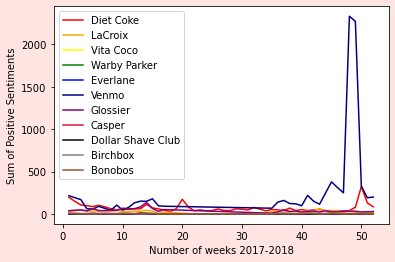

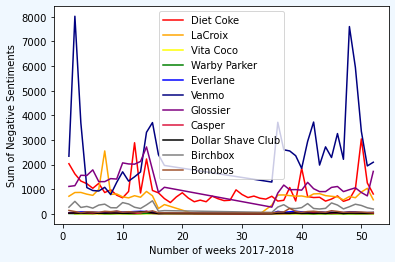

In [16]:
#by About
sentiment_types=['New_Pos','New_Neg','New_Neu','New_Com']
colorlist=['red','orange','yellow','green','blue','navy','purple','crimson','black','grey','sienna']
facecolors=['mistyrose','aliceblue']
ylabels=['Sum of Positive Sentiments','Sum of Negative Sentiments']
for j in range(0,2):
    plt.figure(facecolor=facecolors[j])
    for i in range(0,len(brand_keys)):
        aboutdf=usdf[usdf.About==brand_keys[i]]
        y=aboutdf.groupby(['Weeks'])[sentiment_types[j]].sum()
        x=y.keys()
        plt.plot(x,y,c=colorlist[i])
    plt.legend(brand_keys)
    plt.xlabel('Number of weeks 2017-2018')
    plt.ylabel(ylabels[j])

Seems like people are generally mad about the given brands... at least venmo made a positive progress at the end of the period.

Text(0, 0.5, 'Sum of Positive Sentiments')

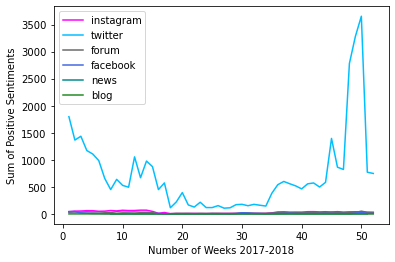

In [17]:
#by Page_Type
Page_Types=['instagram','twitter','forum','facebook','news','blog']
colorlist=['fuchsia','deepskyblue','dimgrey','royalblue','darkcyan','forestgreen']


for i in range(0,len(Page_Types)):
    aboutdf=usdf[usdf.Page_Type==Page_Types[i]]
    y=aboutdf.groupby(['Weeks'])['New_Pos'].sum()
    x=y.keys()
    plt.plot(x,y,c=colorlist[i])
plt.legend(Page_Types)
plt.xlabel('Number of Weeks 2017-2018')
plt.ylabel('Sum of Positive Sentiments')

# Size of Impact of Each Posts

Sponsoring influencers is one of the most popular way to engage with customers nowdays. I thought identifying poweful influencers and sponsoring them to consume CocaCola's product could be a good way to advertise, espeically regarding its low cost compared to tv and actual advertisements.

Seeing the graph above, Twitter seems like the most powerful media in this dataset. This analysis will be focused mainly on twitter. First, I decided to sort out who has the real 

In [18]:
#I looked up on twitter and found that accounts with negative followers are mostly suspended or expired accounts, 
#so I will clean them out.
df=df[df.Followers>=0]
twdf=df[df.Page_Type=='twitter'] #extracting the focus
topauthors=twdf[['Author','Followers','Social_Engagements','Weeks']].sort_values(by=['Followers'],ascending=False).drop_duplicates(subset=['Author']).head(5000)

#find the top 5000 authors sorted by highest number of followers
topauthors['Reach_Ratio']=topauthors.Social_Engagements.div(topauthors.Followers)
topauthors=topauthors.sort_values(by=['Reach_Ratio'],ascending=False).head(500)

#Now with the 500 top authors, filter out people with inactive or unresponsive follower base
avgRR=topauthors.Reach_Ratio.mean()
topauthors=topauthors[topauthors.Reach_Ratio>avgRR] #top authors with Reach_Ratio above average. Now we narrowed it down to 76 people
topauthors.sort_values(by=['Followers'],ascending=False).tail(30)

#It will be pracitically impossible to collaborate with huge official accounts such as Donald Trump, CNN, things like these
#Thus, the stakeholder may review table below to contact for collaboration to these real, unofficial, medium sized accounts.


,Author,Followers,Social_Engagements,Weeks,Reach_Ratio
526272,kenvogel,52301.0,80.0,28,0.001530
460521,sniequist,52297.0,69.0,43,0.001319
3342,PRADACCIA,51455.0,165.0,14,0.003207
661144,paulbloomatyale,50770.0,115.0,10,0.002265
153853,shanebacon,46244.0,99.0,7,0.002141
456950,baseballcrank,44811.0,86.0,6,0.001919
463078,BeatsByESTA,43463.0,150.0,6,0.003451
213342,brandongroeny,43352.0,173.0,49,0.003991
513725,Green_Footballs,42939.0,94.0,50,0.002189
269617,araslanian_,42179.0,599.0,12,0.014201


# Conclusion

## Cleaning

I started off by checking and casting necessary datatypes for each columns. I found that most of the columns had mixed data types of string, null, and numerics. Some of the columns that should only have positive values (counts) had negative values as well so I looked up why it ended up like that. I found that most of those accounts with negative values are deactivated or suspedned, and they seemed like not signigicant enough to make a change in overall anaylsis. Thus I decided to just drop them for efficiency. It also had too many columns for social engagements because they were flattened out for each types of social meida and engagement types, so I just added them up for vertically narrower dataframe. It can be flattened out again if neccesary with the Page_Type column. For further analysis, don't try to just dropna because null values in official means they are unofficial, and it's not an error

## Analysis & Comments for Stakeholders

I was told that the business analyst found that the sentiment given in the original dataset was unsatisfactory. So I did a new analysis using VADER and NLTK. I think this makes more sense because sentiments are not 1-dimensional (mad-happy). I also tagged emotions that could be used further, but I didn't use it in this case because sentiments seemed good enough. 

I used this dataset to find who to collaborate with for promotions. For bigger corporations, It seemed like people are expressing the biggest opinions and talking very much about Venmo, which seems like a great option to collaborate with, for enterprise scale. I suggest to also look for sponsoring smaller accounts because in this era of data overflow, people are looking for more human and personal information especially when they are looking for an opinion of products. Just shown how "brand name+reddit" is always in the suggested search on Google. Therefore, I collected 5000 people with the highest followers, and then 500 people with highest reach ratio (social engagement divided by followers) to filter out fake accounts or with inactive follower base, and then 30 people with the least followers because we are looking for small users but with big enough follower size to make impact with their sponsorships.

For more accurate analaysis, I wish the age of users are verified, have more data on the actual client --DietCoke(CocaCola), and check what happend to Venmo in 2017. It seems like people were very unsatifised with Venmo in the beginning of 2017, according to the negative sentiment graph above. This should be done before deciding to collaborate with Venmo because their repuation may tarnish client's reputation if they decide to collaborate